<a href="https://colab.research.google.com/github/sangnie/lyapunov_calc/blob/master/Calculate_lyapunov_exponents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up

In [1]:
import os
import sys
import copy
import math
import pickle as pkl
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

In [ ]:
!pip install pytorch_lightning
!pip install mod
!pip install blobfile
!pip install wandb
!pip install unidecode

In [3]:
!git clone https://github.com/sangnie/lyapunov_calc.git
sys.path.insert(0,'/content/lyapunov_calc')

Cloning into 'lyapunov_calc'...
remote: Enumerating objects: 834, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 834 (delta 6), reused 4 (delta 4), pack-reused 827
Receiving objects: 100% (834/834), 447.31 MiB | 32.33 MiB/s, done.
Resolving deltas: 100% (75/75), done.
Checking out files: 100% (332/332), done.


In [4]:
from lyapunov_calc import config
from lyapunov_calc.models import RNNModel
from lyapunov_calc.training import train_model, load_checkpoint

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [6]:
dropout = 0.1
uni_param = 0.08
batch_size = 128
max_epoch = 15
learning_rate = 0.002
sch = torch.optim.lr_scheduler.MultiStepLR
sch_params = {'milestones': range(10, 50), 'gamma': 0.95}
max_epoch = 15

In [7]:
!mkdir models
!mkdir LE_stats
!mkdir trials

In [8]:
device = torch.device('cpu')

In [9]:
data_config = config.DataConfig('/content/lyapunov_calc/CharRNN/WP/', input_seq_length=100, target_seq_length=1, train_frac=0.8, val_frac=0.1, test_frac=0.1, batch_size=batch_size)

vocab.pkl or data.pkl detected as stale. Re-running preprocessing...
One-time setup: preprocessing input text file  /content/lyapunov_calc/CharRNN/WP/input.txt ...
Loading text file...
Putting data into tensor...
Saving  /content/lyapunov_calc/CharRNN/WP/vocab.pkl ...
Saving  /content/lyapunov_calc/CharRNN/WP/data.pkl ...
Loading  /content/lyapunov_calc/CharRNN/WP/data.pkl ...
Loading  /content/lyapunov_calc/CharRNN/WP/vocab.pkl ...
None
Cutting off end of data so that it divides evenly
Data load done! Number of data batches in train: 200, val: 25, test: 24


In [10]:
model_type = 'rnn'
hidden_size = 512
model_config = config.ModelConfig(model_type, 1, hidden_size, data_config.input_size, data_config.input_size, dropout, 'uni', device, {'a': -uni_param, 'b':uni_param}, bias = False, id_init_param = 'b')
train_config = config.TrainConfig('models/', batch_size, max_epoch, 'adam', learning_rate, {}, scheduler = sch, scheduler_params= sch_params, start_epoch = 0)
full_config = config.FullConfig(data_config, train_config, model_config)

# Helper fns

In [5]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
def plot_summary(val_losses, idcs, LEs):
    plt.rc('font', family = 'serif')
    plt.rc('xtick', labelsize = 'medium')
    plt.rc('ytick', labelsize = 'medium')
    fontsize = 12
    hidden_size = LEs.shape[1]
    fig= plt.figure(figsize = (10,5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax_max = fig.add_subplot(1, 2, 2)

    idcs = torch.LongTensor(idcs)
    val_lims = [torch.min(val_losses), torch.max(val_losses)]
    plt.rc('ytick', labelsize = 'small')
    plt.rc('xtick', labelsize = 'small')
    axin1 = ax1.inset_axes([0.15, 0.1, 0.38, 0.38])

    for i, idx in enumerate(idcs):
        axin1.plot(range(0,10), LEs[idx, :10], '-o', markersize = 2.5, linewidth = .5, label = idx.item())
        axin1.set_yticks([0, -.5])
    axin1.plot([0, 10], [0, 0], 'white', linewidth = .5)

    axin1.set_xlim([0,9])
    axin1.yaxis.set_minor_locator(MultipleLocator(.1))
    plt.rc('ytick', labelsize = 'medium')
    plt.rc('xtick', labelsize = 'medium')
    for idx in range(len(val_losses)):
        ax1.scatter(range(0,hidden_size), LEs[idx, :], s = .5, color = 'grey', alpha = .1)
    for i, idx in enumerate(idcs):
        ax1.scatter(range(0,hidden_size), LEs[idx, :], s = 2, label = idx.item())
    ax1.set_ylabel(r'$\lambda_i$', fontsize = fontsize)
    ax1.set_xlabel(r'$i$', fontsize = fontsize)
    ax1.set_ylim([-8, 0])
    ax1.set_xlim([0, hidden_size])


    x=  LEs[:, 0][idcs]
    print(LEs.shape)
    # x = np.mean(LEs.numpy(), axis=1)[idcs]
    y = np.array(val_losses)[idcs]
    ax_max.scatter(LEs[:,0], val_losses, color = 'gray', alpha = 0.4)
    for i in range(x.shape[0]):
        ax_max.scatter(x[i], y[i], s = 50)

    ax_max.set_xlabel(r' Max LE, $\lambda_{max}$', fontsize  =12)
    ax_max.set_ylabel('Validation Loss', fontsize = 12)
    
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    

In [12]:
def save_LEs_and_losses(epoch=15, hidden_sizes=[64, 128, 512], base_dir='.'):
  for hidden_size in hidden_sizes:
      print(hidden_size)
      trials = pkl.load(open('{}/trials/{}_trials_{}.p'.format(base_dir, full_config.model.model_type, hidden_size), 'rb'))
      full_config.model.rnn_atts['hidden_size'] = hidden_size
      lcon = config.LyapConfig(le_batch_size, le_seq_length, ON_step = ON, one_hot = True)
      data = lcon.get_input(full_config)
      for trial in trials:
          uni_param = trial['misc']['vals']['param'][0]
          full_config.model.init_params = {'a': -uni_param, 'b':uni_param}
          ckpt = load_checkpoint(full_config, epoch)
          model = ckpt[0].to(full_config.device)
          LE_stats, _ = lcon.calc_lyap(data, model, full_config)
          torch.save(LE_stats, '{}/LE_stats/{}_LE_stats_e{}.p'.format(base_dir, full_config.name(), epoch))

  for hidden_size in hidden_sizes:
      full_config.model.rnn_atts['hidden_size'] = hidden_size
      trials = pkl.load(open('{}/trials/{}_trials_{}.p'.format(base_dir, full_config.model.model_type, hidden_size), 'rb'))
      LE_tensor = torch.zeros((15, hidden_size))
      LE_stds = torch.zeros((15, hidden_size))
      for i, trial in enumerate(trials):
          uni_param = trial['misc']['vals']['param'][0]
          full_config.model.init_params = {'a': -uni_param, 'b':uni_param}
          LE_tensor[i, :], LE_stds[i, :] = torch.load('{}/LE_stats/{}_LE_stats_e{}.p'.format(base_dir, full_config.name(), 15))
      torch.save(LE_tensor, '{}/LE_stats/{}_{}_LEs.p'.format(base_dir, full_config.model.model_type, hidden_size))
      torch.save(LE_stds, '{}/LE_stats/{}_{}_LEerrors.p'.format(base_dir, full_config.model.model_type, hidden_size))

  for hidden_size in hidden_sizes:
      full_config.model.rnn_atts['hidden_size'] = hidden_size
      trials = pkl.load(open('{}/trials/{}_trials_{}.p'.format(base_dir, full_config.model.model_type, hidden_size), 'rb'))
      final_tloss = torch.zeros((15))
      vlosses = torch.zeros((15))
      for i, trial in enumerate(trials):
          uni_param = trial['misc']['vals']['param'][0]
          full_config.model.init_params = {'a': -uni_param, 'b':uni_param}
          _, _, train_loss, val_loss = load_checkpoint(full_config, full_config.train.max_epoch)
          final_tloss[i] = train_loss[-1]
          vlosses[i] = val_loss
      torch.save(final_tloss, '{}/LE_stats/{}_{}_trainLoss.p'.format(base_dir, full_config.model.model_type, hidden_size))
      torch.save(vlosses, '{}/LE_stats/{}_{}_valLoss.p'.format(base_dir, full_config.model.model_type, hidden_size))

# Train RNNs

In [ ]:
model_type = 'rnn'

In [ ]:
def objective(space):
    full_config = space['config']
    param = space['param']
    full_config.model.init_params = {'a': -param, 'b':param}
    model = RNNModel(full_config.model).to(model_config.device)
    optimizer = full_config.train.get_optimizer(model.parameters())
    train_loss, val_loss = train_model(full_config, model, optimizer, verbose = False, save_interval = 3)
    return {
        'loss': train_loss[-1],
        'status': STATUS_OK,
        'eval_time': time.time(),
        'val_loss': val_loss
    }

for hidden_size in [128]:
    print('Hidden Size: {}'.format(hidden_size))
    trials = Trials()

    model_config = config.ModelConfig(model_type, 1, hidden_size, data_config.input_size, data_config.input_size, dropout, 'uni', device, {'a': -uni_param, 'b':uni_param}, bias = False, id_init_param = 'b')
    train_config = config.TrainConfig('models', batch_size, max_epoch, 'adam', learning_rate, {}, scheduler = sch, scheduler_params= sch_params, start_epoch = 0)
    full_config = config.FullConfig(data_config, train_config, model_config)

    space = hp.choice('uni_param',[
        {
            'param': hp.quniform('param', .04, .24, .001),
            'config': full_config
        }    
    ])

    best = fmin(objective, 
                space=space,
                algo=tpe.suggest,
                trials=trials,
                max_evals=15)
    pkl.dump(trials, open('trials/{}_trials_{}.p'.format(full_config.model.model_type, hidden_size), 'wb'))


Hidden Size: 128
  0%|          | 0/15 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


100%|██████████| 15/15 [04:01<00:00, 16.08s/it, best loss: 1.7954215383529664]


# Calculate Lyapunov Exponents

In [11]:
le_batch_size = 10
le_seq_length = 100
ON = 1

In [13]:
save_LEs_and_losses(hidden_sizes=[64, 128, 512])

512


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
0it [00:00, ?it/s]
/content/lyapunov_calc/lyapunov.py:113: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1980.)
  Q, _ = torch.qr(Q, some = True)
100%|██████████| 100/100 [00:26<00:00,  3.78it/s]
0it [00:00, ?it/s]
100%|██████████| 100/100 [00:25<00:00,  3.95it/s]
0it [00:00, ?it/s]
100%|██████████| 100/100 [00:24<00:00,  4.05it/s]
0it [00:00, ?it/s]
100%|██████████| 100/100 [00:25<00:

torch.Size([15, 64])
torch.Size([15, 128])
torch.Size([15, 512])


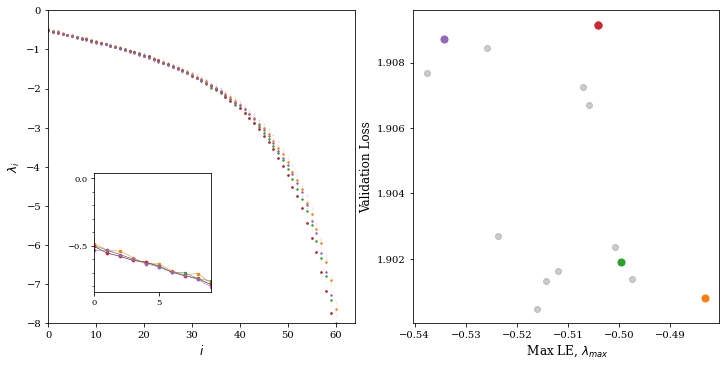

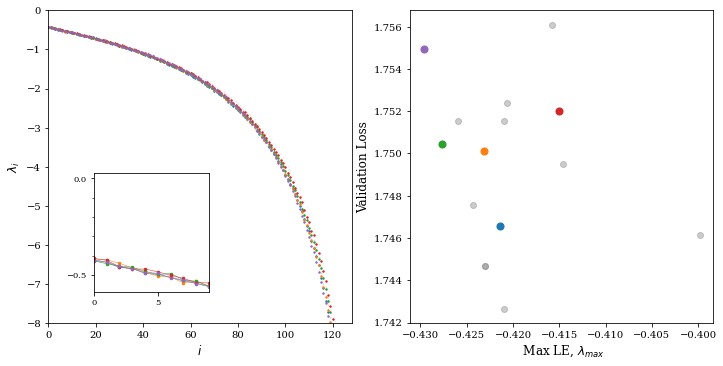

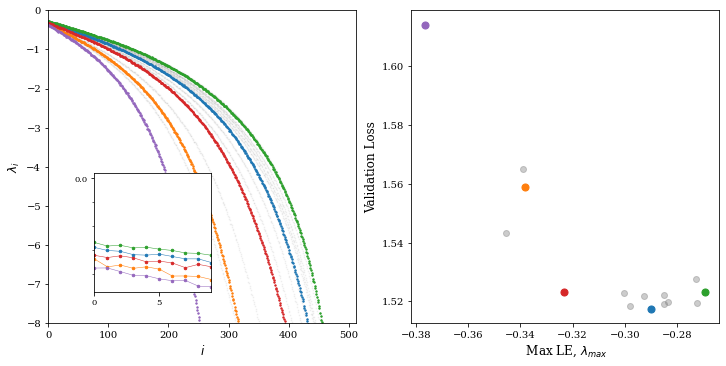

In [23]:
for hidden_size in [64, 128, 512]:
    full_config.model.rnn_atts['hidden_size'] = hidden_size
    full_config.model.model_type = model_type
    LEs = torch.load('LE_stats/{}_{}_LEs.p'.format(full_config.model.model_type, hidden_size))
    train_loss = torch.load('LE_stats/{}_{}_trainLoss.p'.format(full_config.model.model_type, hidden_size))
    val_loss = torch.load('LE_stats/{}_{}_valLoss.p'.format(full_config.model.model_type, hidden_size))
    plot_summary(val_loss, [0,1,2,4,8], LEs)